# **Clustering + Symptoms follow-up (Decision tree)**

The datasets used can be found in :
1. https://github.com/anujdutt9/Disease-Prediction-from-Symptoms
2. https://www.kaggle.com/itachi9604/disease-symptom-description-dataset?select=symptom_precaution.csv

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score

Symptom_severity dataframe show how critical a symptom is.

In [ ]:
Symptom_severity=pd.read_csv('/content/drive/MyDrive/Disease_Prediction_dataset/Symptom-severity.csv')
Symptom_severity.head()

,Symptom,weight
0,itching,1
1,skin_rash,3
2,nodal_skin_eruptions,4
3,continuous_sneezing,4
4,shivering,5


symptom_Description dataframe contains the discription of each disease.

In [ ]:
symptom_Description=pd.read_csv('/content/drive/MyDrive/Disease_Prediction_dataset/symptom_Description.csv')
symptom_Description.head()

,Disease,Description
0,Drug Reaction,An adverse drug reaction (ADR) is an injury ca...
1,Malaria,An infectious disease caused by protozoan para...
2,Allergy,An allergy is an immune system response to a f...
3,Hypothyroidism,"Hypothyroidism, also called underactive thyroi..."
4,Psoriasis,Psoriasis is a common skin disorder that forms...


symptom_precaution dataframe contains up to 4 precautions to each disease.

In [ ]:
symptom_precaution=pd.read_csv('/content/drive/MyDrive/Disease_Prediction_dataset/symptom_precaution.csv')
symptom_precaution.head()

,Disease,Precaution_1,Precaution_2,Precaution_3,Precaution_4
0,Drug Reaction,stop irritation,consult nearest hospital,stop taking drug,follow up
1,Malaria,Consult nearest hospital,avoid oily food,avoid non veg food,keep mosquitos out
2,Allergy,apply calamine,cover area with bandage,NaN,use ice to compress itching
3,Hypothyroidism,reduce stress,exercise,eat healthy,get proper sleep
4,Psoriasis,wash hands with warm soapy water,stop bleeding using pressure,consult doctor,salt baths


Training and Tesing dataframes contains 132 symptoms columns and 1 target column containing the disease.

In [ ]:
Training=pd.read_csv('/content/drive/MyDrive/Disease_Prediction_dataset/Training.csv')
Testing=pd.read_csv('/content/drive/MyDrive/Disease_Prediction_dataset/Testing.csv')
Training.head()
#Testing.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,muscle_wasting,vomiting,burning_micturition,spotting_ urination,fatigue,weight_gain,anxiety,cold_hands_and_feets,mood_swings,weight_loss,restlessness,lethargy,patches_in_throat,irregular_sugar_level,cough,high_fever,sunken_eyes,breathlessness,sweating,dehydration,indigestion,headache,yellowish_skin,dark_urine,nausea,loss_of_appetite,pain_behind_the_eyes,back_pain,constipation,abdominal_pain,...,toxic_look_(typhos),depression,irritability,muscle_pain,altered_sensorium,red_spots_over_body,belly_pain,abnormal_menstruation,dischromic _patches,watering_from_eyes,increased_appetite,polyuria,family_history,mucoid_sputum,rusty_sputum,lack_of_concentration,visual_disturbances,receiving_blood_transfusion,receiving_unsterile_injections,coma,stomach_bleeding,distention_of_abdomen,history_of_alcohol_consumption,fluid_overload.1,blood_in_sputum,prominent_veins_on_calf,palpitations,painful_walking,pus_filled_pimples,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Unnamed: 133
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection,NaN
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection,NaN
2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection,NaN
3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection,NaN
4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection,NaN


In [ ]:
Training.drop(['Unnamed: 133'],axis=1,inplace=True)

In [ ]:
Training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Columns: 133 entries, itching to prognosis
dtypes: int64(132), object(1)
memory usage: 5.0+ MB


## PS: most of the data are duplicated.

In [ ]:
Training.duplicated().sum()

4616

## clustering

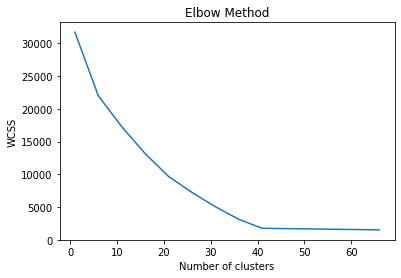

In [ ]:


wcss = []
for i in range(1, 70,5):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(Training.drop(['prognosis'],axis=1))
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 70,5), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=41, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(Training.drop(['prognosis'],axis=1))

In [ ]:
y_df=pd.DataFrame({'y_actual':list(Training['prognosis']),'y_pred':pred_y})
y_df.head()

,y_actual,y_pred
0,Fungal infection,4
1,Fungal infection,4
2,Fungal infection,4
3,Fungal infection,4
4,Fungal infection,4


In [ ]:
#mapping clusters numbers to names
pred_name={}
for i in range(41):
  pred_name[i] = y_df[y_df['y_pred']==i]['y_actual'].value_counts().index[0]
  #print(f"cluster {i} : \n{y_df[y_df['y_pred']==i]['y_actual'].value_counts()}\n")
#pred_name
y_df['mapped_clusters'] = y_df['y_pred'].replace(pred_name)
y_df.head()

,y_actual,y_pred,mapped_clusters
0,Fungal infection,4,Fungal infection
1,Fungal infection,4,Fungal infection
2,Fungal infection,4,Fungal infection
3,Fungal infection,4,Fungal infection
4,Fungal infection,4,Fungal infection


In [ ]:
#reducing the dimention to 2D
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(Training.drop(['prognosis'],axis=1))
my_palette=sns.color_palette("bright", 42)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4920 samples in 0.098s...
[t-SNE] Computed neighbors for 4920 samples in 6.884s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4920
[t-SNE] Computed conditional probabilities for sample 2000 / 4920
[t-SNE] Computed conditional probabilities for sample 3000 / 4920
[t-SNE] Computed conditional probabilities for sample 4000 / 4920
[t-SNE] Computed conditional probabilities for sample 4920 / 4920
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.842476
[t-SNE] KL divergence after 300 iterations: 0.779964


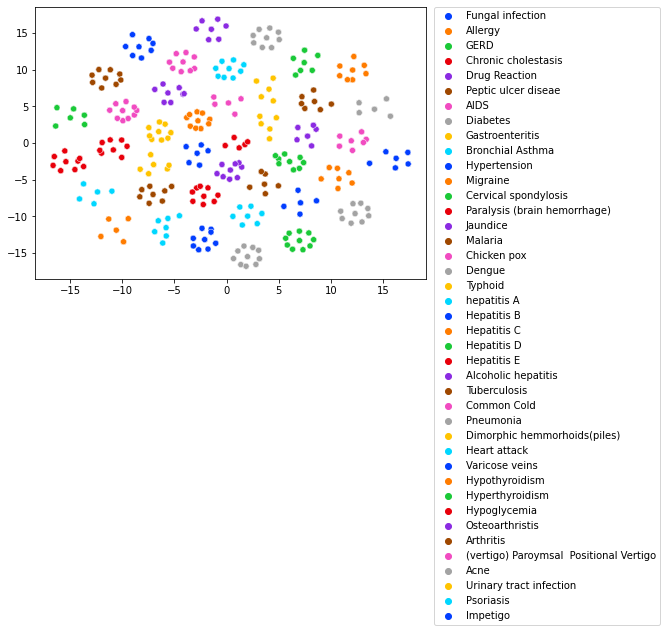

In [ ]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue= y_df['mapped_clusters'],palette=my_palette[:41]);
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [ ]:
df=pd.DataFrame({'X':tsne_results[:,0],'Y':tsne_results[:,1],'clusters':y_df['mapped_clusters'],'actual':y_df['y_actual']})
fig=px.scatter(df,x='X',y='Y',hover_name='actual',color='clusters')
fig.show()

In [ ]:
# a function that calculates silhouete and cappa scores
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import cohen_kappa_score
def evaluate_clusters(train_df, actual_y, pred_y):
  silhouette_avg = silhouette_score(train_df, pred_y)
  kappa_score = cohen_kappa_score(pred_y, actual_y)
  return (silhouette_avg, kappa_score)

In [ ]:
silhouette_avg, kappa_score=evaluate_clusters(Training.drop(['prognosis'],axis=1), y_df['y_actual'], y_df['mapped_clusters'])
print(f'avg silhouette score = {silhouette_avg} \nkappa score = { kappa_score}')

avg silhouette score = 0.7542265247149782 
kappa score = 1.0


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print("Report : \n",classification_report(y_df['mapped_clusters'],y_df['y_actual']))

Report : 
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00       120
                                   AIDS       1.00      1.00      1.00       120
                                   Acne       1.00      1.00      1.00       120
                    Alcoholic hepatitis       1.00      1.00      1.00       120
                                Allergy       1.00      1.00      1.00       120
                              Arthritis       1.00      1.00      1.00       120
                       Bronchial Asthma       1.00      1.00      1.00       120
                   Cervical spondylosis       1.00      1.00      1.00       120
                            Chicken pox       1.00      1.00      1.00       120
                    Chronic cholestasis       1.00      1.00      1.00       120
                            Common Cold       1.00      1.00      1.00       120
                

In [ ]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=1, min_samples=2).fit(Training.drop(['prognosis'],axis=1))
n_clusters=len(np.unique(dbscan.labels_))
print(f"number of clusters = {n_clusters}")
pred_y_db=dbscan.fit_predict(Training.drop(['prognosis'],axis=1))

number of clusters = 41


In [ ]:
#mapping clusters numbers to names
y_df=pd.DataFrame({'y_actual':list(Training['prognosis']),'y_pred':pred_y_db})
pred_name={}
for i in range(41):
  pred_name[i] = y_df[y_df['y_pred']==i]['y_actual'].value_counts().index[0]
  #print(f"cluster {i} : \n{y_df[y_df['y_pred']==i]['y_actual'].value_counts()}\n")
#pred_name
y_df['mapped_clusters'] = y_df['y_pred'].replace(pred_name)
y_df.head()

,y_actual,y_pred,mapped_clusters
0,Fungal infection,0,Fungal infection
1,Fungal infection,0,Fungal infection
2,Fungal infection,0,Fungal infection
3,Fungal infection,0,Fungal infection
4,Fungal infection,0,Fungal infection


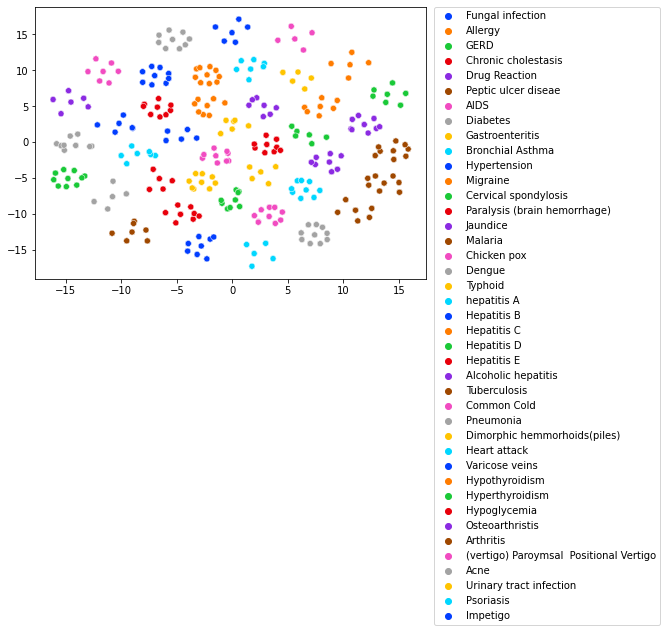

In [ ]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue= y_df['mapped_clusters'],palette=my_palette[:41]);
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [ ]:
df=pd.DataFrame({'X':tsne_results[:,0],'Y':tsne_results[:,1],'clusters':pred_y_db,'actual':list(Training['prognosis'])})
fig=px.scatter(df,x='X',y='Y',hover_name='actual',color='clusters')
fig.show()

In [ ]:
y_df[y_df['y_actual']!= y_df['mapped_clusters']]

,y_actual,y_pred,mapped_clusters


In [ ]:
silhouette_avg, kappa_score=evaluate_clusters(Training.drop(['prognosis'],axis=1), y_df['y_actual'], y_df['mapped_clusters'])
print(f'avg silhouette score = {silhouette_avg} \nkappa score = { kappa_score}')

avg silhouette score = 0.7542265247149782 
kappa score = 1.0


In [ ]:
clean_df =Training.drop_duplicates()

In [ ]:
clean_df.columns = clean_df.columns.str.replace(' ', '')

In [ ]:
'spotting_urination' in clean_df.columns

True

In [ ]:
clean_df.to_csv("clean_data.csv",index=False)

In [ ]:
clean_df=pd.read_csv('clean_data.csv')

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
def get_next_symptom(old_symptoms_yes,old_symptoms_no,clean_df= clean_df):
  selected= clean_df.copy()
  for sym in old_symptoms_yes:
    selected = selected[selected[sym]== 1]
  for sym in old_symptoms_no:
    selected = selected[selected[sym]== 0]
  X= selected.drop(['prognosis'],axis=1)
  Y = selected['prognosis']
  clf = DecisionTreeClassifier(random_state=0)
  clf = clf.fit(X,Y)
  
  text_representation = tree.export_text(clf,feature_names=clean_df.columns[:-1].tolist())
  #print(text_representation)
  if text_representation.split('\n')[0].split(' ')[1] == 'class:': 
    return None
  return text_representation.split('\n')[0].split(' ')[1]



In [ ]:
get_next_symptom(clean_df,['skin_rash','itching'],[])

'red_spots_over_body'

In [ ]:
get_next_symptom(clean_df,['skin_rash','itching','red_spots_over_body'],[])

In [ ]:
get_next_symptom(old_symptoms_yes=['skin_rash','itching'],old_symptoms_no=['red_spots_over_body'])

'spotting_urination'

In [ ]:
get_next_symptom(Training,['skin_rash','red_spots_over_body'])

'pain_behind_the_eyes'